In [ ]:
#############
# İŞ PROBLEMİ
#############

""""
FLO müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor.

Buna yönelik olarak müşterilerin davranışları tanımlanacak ve bu davranışlardaki öbeklenmelere göre gruplar oluşturulacak.

""""

In [65]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
warnings.simplefilter(action="ignore", category=Warning)

pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.3f' % x)
pd.set_option("display.width",500)

In [15]:
###########################
# Görev 1: Veriyi Hazırlama
###########################

# Adım 1: flo_data_20K.csv verisini okutunuz.

df = pd.read_csv("flo_data_20k.csv")
df.head()

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)    

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [20]:
# Adım 2: Müşterileri segmentlerken kullanacağınız değişkenleri seçiniz.

# Tenure (Müşterinin yaşı), Recency (en son kaç gün önce alışveriş yaptığı) gibi yeni değişkenler oluşturabilirsiniz

df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
# Müşterinin e-ticaret sitesi/mağaza ile ilk kontağından bu yana geçen zaman olarak geçer.
# (Bugünden) - (ilk sipariş tarihi) çıkartılmasıyla bulunabilir.

df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
# Müşterinin en son kaç gün önce alışveriş yaptığı, bilgisini verir.
# Hesaplanması genellikle, (bugünden) - (son sipariş tarihinin) çıkartılmasıyla elde edilir.

df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
# Müşterinin ne sıklıkla alışveriş yaptığını, ne sıklıkla siteye giriş yaptığını gösteren metriktir.
# Genellikle (Online Sipariş Sayısı) + (Offline Sipariş Sayısı) kodunun saydırılmasıyla sonuç verir.

df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']
# Müşterinin harcamalarının toplamıdır. E-ticaret sitesine getirdiği ciro.
# Genellikle (Online Harcama Miktarı) + (Offline Harcama Miktarı) kodunun saydırılmasıyla sonuç verir.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

Observations: 19945
Variables: 21
cat_cols: 7
num_cols: 8
cat_but_car: 6
num_but_cat: 7
   order_channel_Desktop_1_1  Ratio
0                      17210 86.287
1                       2735 13.713
##########################################
   order_channel_Ios App_1_1  Ratio
0                      17112 85.796
1                       2833 14.204
##########################################
   order_channel_Mobile_1_1  Ratio
0                     15063 75.523
1                      4882 24.477
##########################################
   last_order_channel_Desktop_1_1  Ratio
0                           18259 91.547
1                            1686  8.453
##########################################
   last_order_channel_Ios App_1_1  Ratio
0                           18249 91.497
1                            1696  8.503
##########################################
   last_order_channel_Mobile_1_1  Ratio
0                          16773 84.096
1                           3172 15.904
##########

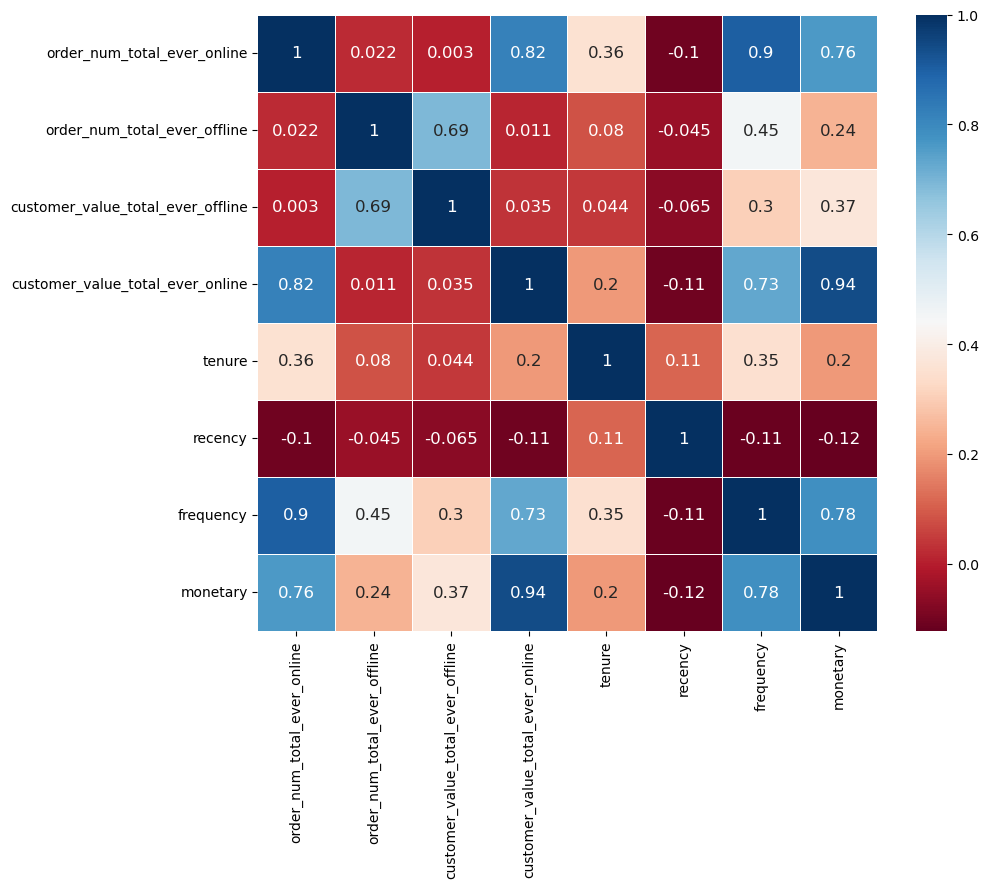

   order_channel_Desktop_1_1  Ratio
0                      17210 86.287
1                       2735 13.713
##########################################
   order_channel_Ios App_1_1  Ratio
0                      17112 85.796
1                       2833 14.204
##########################################
   order_channel_Mobile_1_1  Ratio
0                     15063 75.523
1                      4882 24.477
##########################################
   last_order_channel_Desktop_1_1  Ratio
0                           18259 91.547
1                            1686  8.453
##########################################
   last_order_channel_Ios App_1_1  Ratio
0                           18249 91.497
1                            1696  8.503
##########################################
   last_order_channel_Mobile_1_1  Ratio
0                          16773 84.096
1                           3172 15.904
##########################################
   last_order_channel_Offline_1_1  Ratio
0             

In [33]:
# Kategorik Değişken Özetleme
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

# Sayısal Değişken Özetleme
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
        
# Veri seti içerisindeki sayısal değişkenlerin birbirleri arasındaki korelasyon hesaplanması     
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

# Kategorik, Sayısal ve Kardinal değişkenleri verir.    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

# Sayısal değişkenlerin incelenmesi
print(df[num_cols].describe().T)

# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

# Kategorik değişkenlerin sayısal değerlere dönüştürülmesi işlemidir
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [51]:
############################################
# Görev 2: K-Means ile Müşteri Segmentasyonu
############################################
    
# Adım 1: Değişkenleri standartlaştırınız
sc = MinMaxScaler((0, 1))
df_new = sc.fit_transform(df[num_cols]) # Kategorik Değişkenleri standartlaştırdık.
df_new = pd.DataFrame(df_new, columns=num_cols) # Yeni df'ye atadık.
df_new = df_new.merge(df.iloc[:, -7:], left_index=True, right_index=True) # df'deki son 7 veriyi df_new'e ekliyoruz.
df_new.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_channel_Desktop_1_1_1,order_channel_Ios App_1_1_1,order_channel_Mobile_1_1_1,last_order_channel_Desktop_1_1_1,last_order_channel_Ios App_1_1_1,last_order_channel_Mobile_1_1_1,last_order_channel_Offline_1_1_1
0,0.015,0.000,0.007,0.017,0.068,0.255,0.015,0.020,0,0,0,0,0,0,1
1,0.090,0.009,0.008,0.041,0.514,0.282,0.095,0.043,0,0,0,0,0,1,0
2,0.010,0.009,0.010,0.008,0.179,0.504,0.015,0.012,0,0,0,0,0,0,0
3,0.000,0.000,0.002,0.002,0.046,0.364,0.000,0.002,0,0,0,0,0,0,0
4,0.000,0.000,0.002,0.003,0.217,0.230,0.000,0.004,1,0,0,1,0,0,0


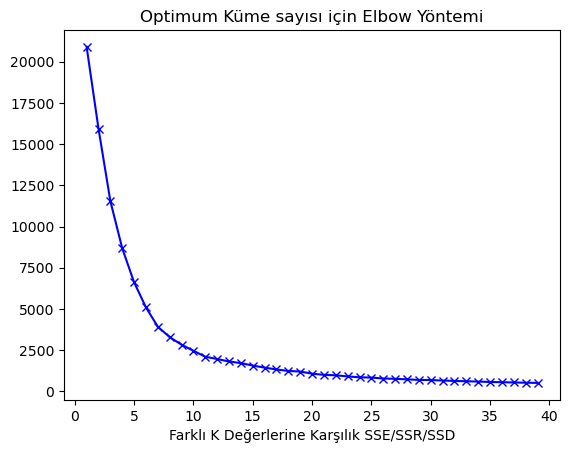

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 39,
 'n_init': 'warn',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [62]:
# Adım 2: Optimum küme sayısını belirleyiniz.
############################################
kmeans = KMeans()
ssd = []
K = range(1,40)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_new)
    ssd.append(kmeans.inertia_)
    
plt.plot(K,ssd,"bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show(block=True)

kmeans.get_params()

In [61]:
kmeans.cluster_centers_

""""
k-means kümeleme modelindeki küme merkezlerini içeren bir NumPy dizisi döndürür.
Her bir merkez, bir kümenin merkezini temsil eder.
""""
kmeans.labels_

""""
Her örneğin atanmış olduğu küme etiketlerini içeren bir NumPy dizisi döndürür.
Bu dizideki indisler, örneklerin indisleriyle aynıdır ve her bir örnek için hangi kümeye ait olduğunu belirtir.
""""

kmeans.inertia_

""""
Kümeleme sonucunda elde edilen toplam karesel hatayı (inertia) döndürür. 
Bu değer, her bir örneğin küme merkezine olan uzaklıklarının karelerinin toplamıdır.
Kümeleme sonucunun ne kadar iyi olduğunu gösteren bir ölçüdür.
""""

520.6951646089748

In [ ]:
# Elbow yöntemi ile optimum küme sayımızı hesaplayalım.
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_new)
elbow.show(block=True)

# Optimum küme sayısı
elbow.elbow_value_
# Optimum Küme Sayısı -> 7 

In [ ]:
# Adım 3: Modelinizi oluşturunuz ve müşterilerinizi segmentleyiniz.

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_new)

# Etiketlerin değişken atamasını yapıyoruz.
clusters = kmeans.labels_

# Mevcut DF içerisine küme sayılarını ekliyoruz.
df["cluster"] = clusters
df["cluster"] = df["cluster"] + 1

In [ ]:
# Kümelere göre dağılımını kontrol edelim
def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
Ratio_(df, "cluster")

In [ ]:
# Adım 4: Her bir segmenti istatistiksel olarak inceleyeniz.

df.groupby("cluster").agg(["mean", "median", "count", "sum"]).T

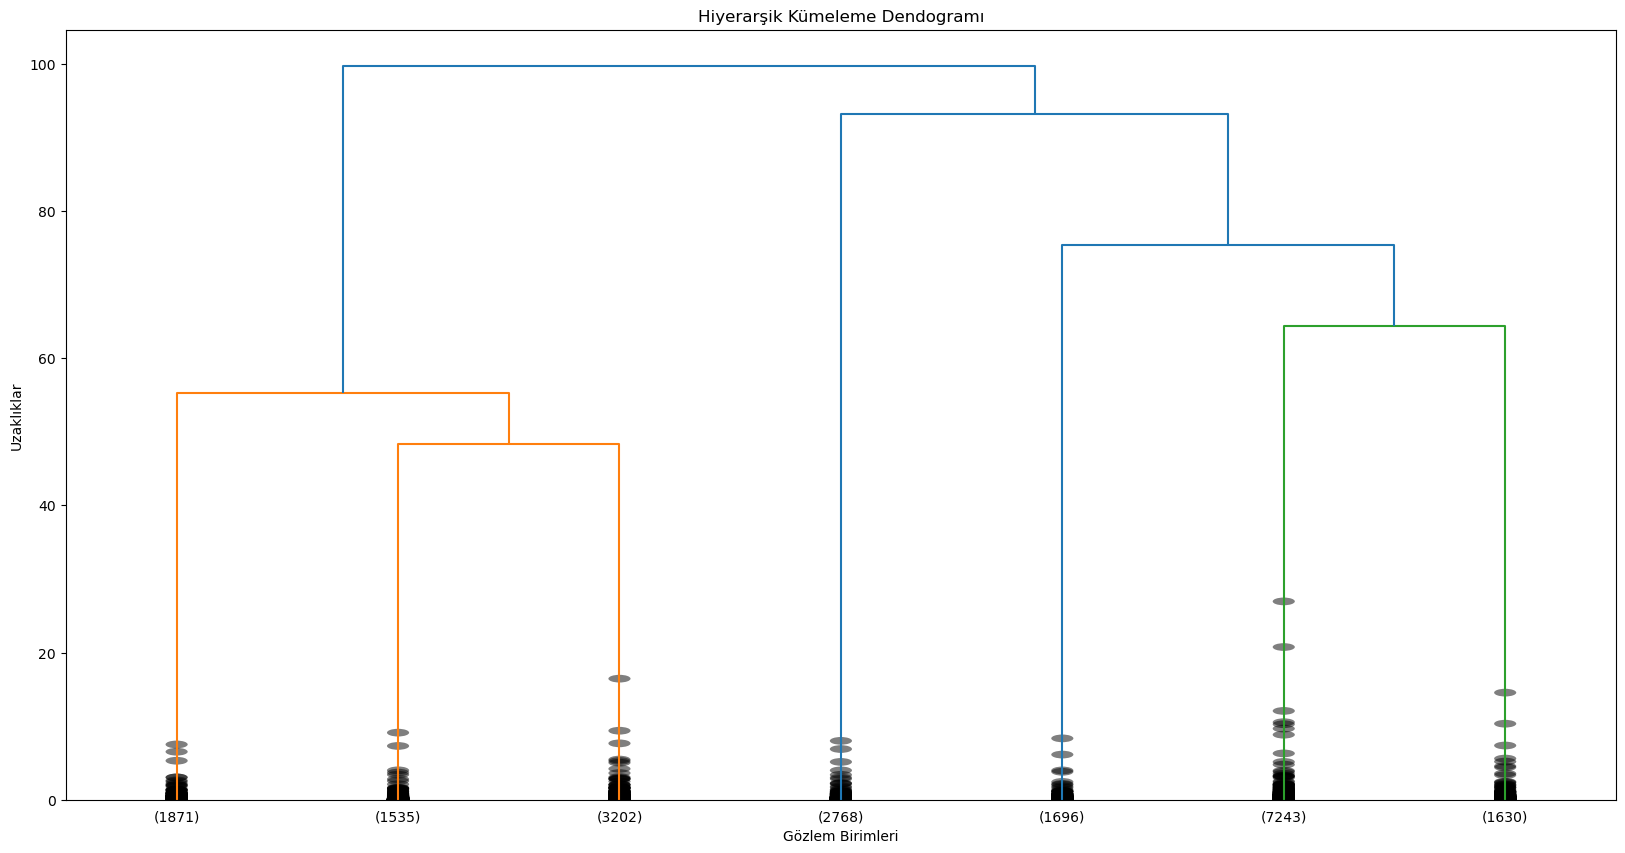

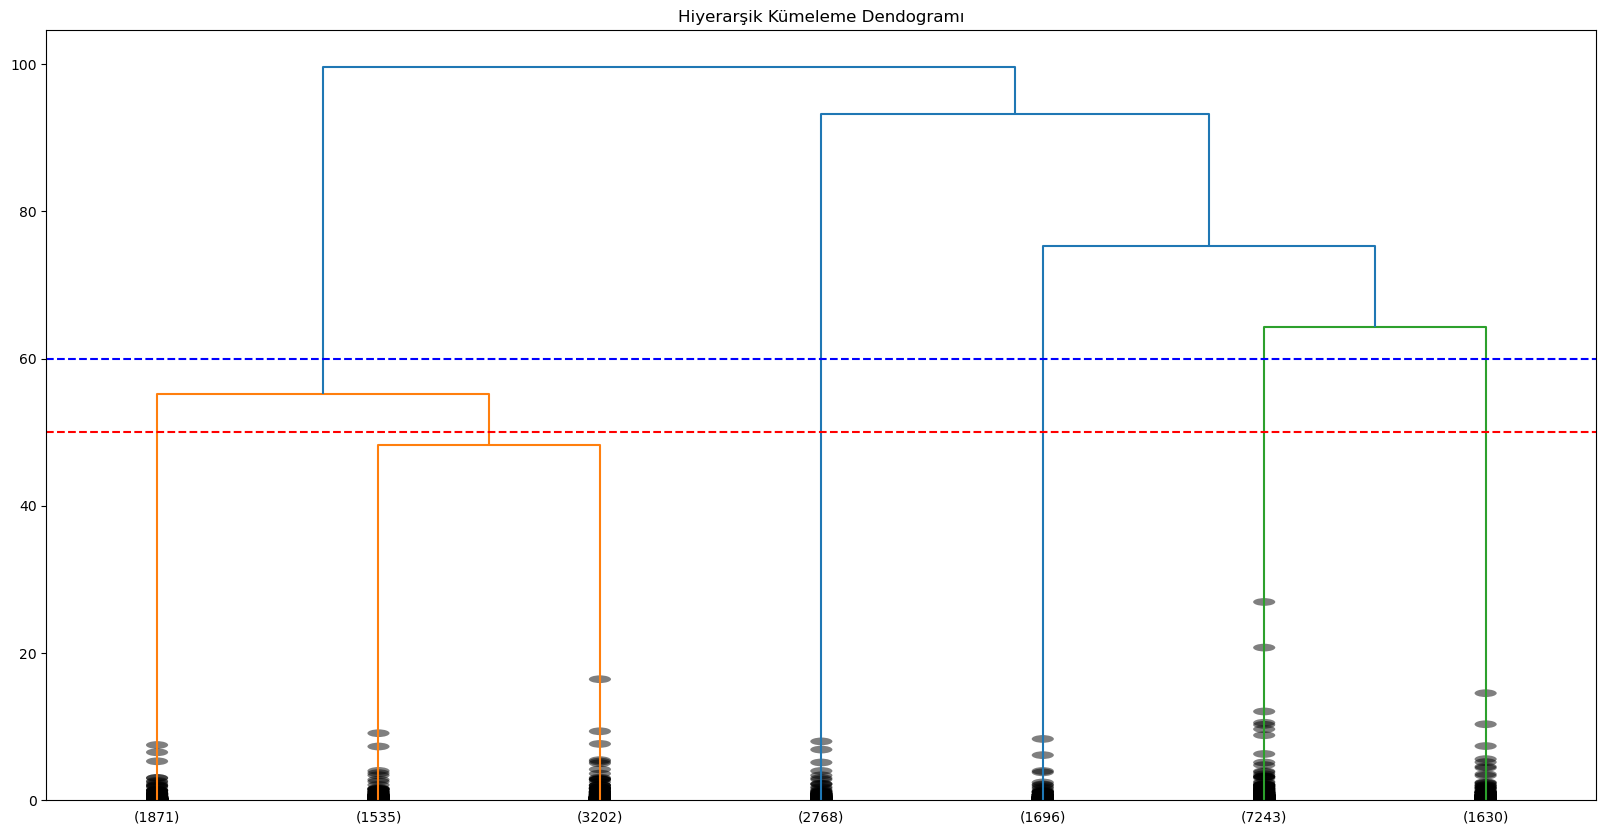

In [66]:
############################################################
# Görev 3: Hierarchical Clustering ile Müşteri Segmentasyonu
############################################################

# Adım 1: Görev 2'de standırlaştırdığınız dataframe'i kullanarak optimum küme sayısını belirleyiniz

hc_ward = linkage(df_new, "ward") 
""""
Linkage fonksiyonu, veri seti üzerinde hiyerarşik kümeleme yapmak için kullanılır.

"ward" metriği, hiyerarşik kümeleme algoritmasında kullanılan bir mesafe metriğidir

""""

plt.figure(figsize=(20, 10)) 
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_ward,                # Oluşturulan küme bağlantı matrisi.
            truncate_mode="lastp", 
            p=7,
            show_contracted=True,  # Küçük kümelerin birleştirilerek gösterilmesini sağlar.
            leaf_font_size=10)
plt.show(block=True)

# Yukarıda ki dendrogramı biraz daha özelleştirmek için kullandık.
plt.figure(figsize=(20, 10)) 
plt.title("Hiyerarşik Kümeleme Dendogramı")
dend = dendrogram(hc_ward,
                 truncate_mode="lastp",
                  p=7,
                  show_contracted=True,
                  leaf_font_size=10)
plt.axhline(y=60, color="b", linestyle="--")
plt.axhline(y=50, color="r", linestyle="--")
plt.show(block=True)

In [69]:
# Adım 2: Modelinizi oluşturunuz ve müşterileriniz segmentleyiniz.

h_cluster = AgglomerativeClustering(n_clusters=6, linkage="ward")
# AgglomerativeClustering sınıfı, veri setini belirtilen bağlantı yöntemi ve küme sayısı temelinde kümeleyen bir sınıftır

h_clusters = h_cluster.fit_predict(df_new)

df["h_cluster"] = h_clusters
df["h_cluster"] = df["h_cluster"] + 1
df.head()

,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_channel_Desktop_1_1_1,order_channel_Ios App_1_1_1,order_channel_Mobile_1_1_1,last_order_channel_Desktop_1_1_1,last_order_channel_Ios App_1_1_1,last_order_channel_Mobile_1_1_1,last_order_channel_Offline_1_1_1,h_cluster
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],1253,1134,5.000,939.370,0,0,0,0,0,0,1,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2613,1144,21.000,2013.550,0,0,0,0,0,1,0,2
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",1591,1225,5.000,585.320,0,0,0,0,0,0,0,2
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",1185,1174,2.000,121.970,0,0,0,0,0,0,0,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.000,1.000,49.990,159.990,[AKTIFSPOR],1707,1125,2.000,209.980,1,0,0,1,0,0,0,3


In [70]:
# Kümelere göre dağılımını kontrol edelim

def Ratio_(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
        
Ratio_(df, "h_cluster")

   h_cluster  Ratio
2       7243 36.315
1       4737 23.750
6       2768 13.878
4       1871  9.381
5       1696  8.503
3       1630  8.172
##########################################


In [71]:
# Adım 3: Her bir segmenti istatistiksel olarak inceleyeniz

df.groupby("h_cluster").agg(["mean", "median", "count", "sum"]).T

h_cluster                                          1            2           3           4           5           6
order_num_total_ever_online       mean         2.355        3.927       3.748       2.134       3.344       2.410
                                  median       1.000        2.000       2.000       1.000       2.000       1.000
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum      11157.000    28445.000    6109.000    3993.000    5671.000    6671.000
order_num_total_ever_offline      mean         2.373        1.734       1.647       2.272       1.724       1.630
                                  median       2.000        1.000       1.000       2.000       1.000       1.000
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum      11242.000    12559.000    2685.000    4251.000    2924.000    4512.000
customer_value_total_ever_offline mean       343.476      214.514     215.548     306.587     227.044     207.255
                                  median     249.950      149.990     149.990     230.950     159.990     149.980
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum    1627046.850  1553724.190  351343.400  573623.740  385067.130  573680.890
customer_value_total_ever_online  mean       362.597      638.010     609.416     276.529     607.343     375.566
                                  median     209.990      390.450     348.110     183.730     390.565     235.965
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum    1717620.800  4621103.300  993348.760  517386.420 1030054.290 1039567.540
tenure                            mean      1954.688     1770.277    1897.818    1981.445    1749.587    1754.096
                                  median    1730.000     1679.000    1708.000    1843.000    1668.000    1666.000
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum    9259357.000 12822117.000 3093443.000 3707284.000 2967300.000 4855339.000
recency                           mean      1191.415     1160.223    1166.913    1198.764    1177.446    1161.667
                                  median    1163.000     1139.000    1144.500    1170.000    1160.000    1147.000
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum    5643731.000  8403497.000 1902069.000 2242888.000 1996949.000 3215493.000
frequency                         mean         4.729        5.661       5.395       4.406       5.068       4.040
                                  median       4.000        4.000       4.000       4.000       4.000       3.000
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum      22399.000    41004.000    8794.000    8244.000    8595.000   11183.000
monetary                          mean       706.073      852.523     824.965     583.116     834.388     582.821
                                  median     531.150      615.690     563.940     479.700     603.120     439.370
                                  count     4737.000     7243.000    1630.000    1871.000    1696.000    2768.000
                                  sum    3344667.650  6174827.490 1344692.160 1091010.160 1415121.420 1613248.430
order_channel_Desktop_1_1_1       mean         0.324        0.000       0.736       0.000       0.000       0.000
                                  median       0.000        0.000       1.000       0.000       0.000       0.000
          